In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense,BatchNormalization,Conv2D,MaxPool2D
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time


Using TensorFlow backend.


In [2]:
img_width, img_height = 128,128
# loading up our datasets
train_data_dir = r'C:\Users\personal\Desktop\COVID_Mini_Project\xray_dataset_covid19\train' 
#validation_data_dir = ‘data/validation’ 
test_data_dir = r'C:\Users\personal\Desktop\COVID_Mini_Project\xray_dataset_covid19\test'

In [3]:
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 32

# Image Augmentation

In [4]:
def get_generator(path):
    generator = datagen.flow_from_directory( 
        path, 
        target_size=(img_width, img_height), 
        batch_size=batch_size, 
        class_mode="categorical", 
        shuffle=False) 

    nb_samples = len(generator.filenames) 
    num_classes = len(generator.class_indices) 

    predict_size_train = int(math.ceil(nb_samples / batch_size)) 
    # get the class labels for the training data, in the original order 
    labels = generator.classes 

    # convert the training labels to categorical vectors 
    labels = to_categorical(labels, num_classes=num_classes)
    return (generator,nb_samples,predict_size_train,labels)

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255) 

In [6]:
generator_train,nb_train_samples,predict_size_train,train_labels = get_generator(train_data_dir)
generator_test,nb_test_samples,predict_size_test,test_labels    = get_generator(test_data_dir)
num_classes = 3
class_labels=list(generator_train.class_indices.keys())

Found 222 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


# Apply Pre-trained Model

In [7]:
def apply_pretrainedModel(pretrained_model,generator,predict_size):
    return pretrained_model.predict_generator(generator, predict_size) 

# Apply transfer Learning

In [8]:
def cnn_after_pretrainedModel(input_shape):
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape)) 
    model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.5)) 
    model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.3)) 
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
       optimizer=optimizers.Adam(lr=1e-4),
       metrics=['acc'])
    return model;

In [9]:
def transfer_learning(pretrained_model,epochs=25):
    #Appling Pretrained Model to train and test datasets
    train_data = apply_pretrainedModel(pretrained_model,generator_train,predict_size_train)
    test_data  = apply_pretrainedModel(pretrained_model,generator_test,predict_size_test)
    model      = cnn_after_pretrainedModel(train_data.shape[1:])
    history = model.fit(train_data, train_labels, 
       epochs=epochs,
       batch_size=batch_size, 
       validation_data=(test_data, test_labels))
    (eval_loss, eval_accuracy) = model.evaluate( 
        test_data, test_labels, batch_size=batch_size,     verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
    print("[INFO] Loss: {}".format(eval_loss))
    
    return train_data,test_data,model,history,eval_accuracy

In [10]:
def plot_graphs(history):
    #Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# Build Model  VGG

In [11]:
#Loading Pre-trained Model
model_name="VGG"
pretrained_model_vgg  = applications.VGG16(include_top=False, weights='imagenet')
train_data,test_data,model_vgg,history_vgg,acc_vgg = transfer_learning(pretrained_model_vgg)
print()

C:\Users\personal\anaconda3\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 222 samples, validate on 60 samples
Epoch 1/25
222/222 [==============================] - 0s 2ms/step - loss: 1.3336 - acc: 0.3288 - val_loss: 0.9229 - val_acc: 0.5333
Epoch 2/25
222/222 [==============================] - 0s 1ms/step - loss: 1.0261 - acc: 0.5000 - val_loss: 0.7905 - val_acc: 0.7833
Epoch 3/25
222/222 [==============================] - 0s 1ms/step - loss: 0.8263 - acc: 0.7027 - val_loss: 0.6463 - val_acc: 0.8833
Epoch 4/25
222/222 [==============================] - 0s 1ms/step - loss: 0.7115 - acc: 0.7477 - val_loss: 0.5346 - val_acc: 0.9333
Epoch 5/25
222/222 [==============================] - 0s 1ms/step - loss: 0.5520 - acc: 0.8604 - val_loss: 0.4270 - val_acc: 0.9333
Epoch 6/25
222/222 [==============================] - 0s 994us/step - loss: 0.5319 - acc: 0.8333 - val_loss: 0.3559 - val_acc: 0.9833
Epoch 7/25
222/222 [==============================] - 0s 1ms/step - loss: 0.4280 - acc: 0.8739 - val_loss: 0.2977 - val_acc: 0.9500
Epoch 8/25
222/222 [=========

# Visualise VGG training and testing

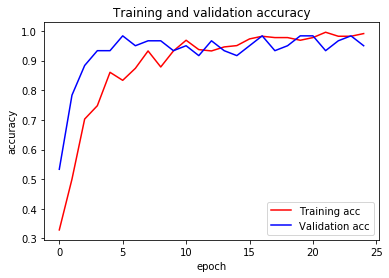

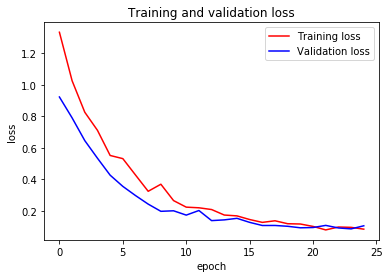

In [12]:
plot_graphs(history_vgg)
preds=np.round(model_vgg.predict(test_data),0)

# Performance Metrics

In [13]:
classify_matrics_vgg=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_vgg)

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        20
      NORMAL       1.00      0.85      0.92        20
   PNEUMONIA       0.87      1.00      0.93        20

   micro avg       0.95      0.95      0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60
 samples avg       0.95      0.95      0.95        60



## Applying GOOGLE NET 

In [14]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_googleNet  = applications.InceptionV3(include_top=False, weights='imagenet')
train_data,test_data,model_googleNet,history_googleNet,acc_googleNet = transfer_learning(pretrained_model_googleNet)

C:\Users\personal\anaconda3\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 222 samples, validate on 60 samples
Epoch 1/25
222/222 [==============================] - 1s 2ms/step - loss: 2.9368 - acc: 0.3694 - val_loss: 0.7374 - val_acc: 0.6333
Epoch 2/25
222/222 [==============================] - 0s 1ms/step - loss: 1.4691 - acc: 0.5495 - val_loss: 0.5024 - val_acc: 0.7667
Epoch 3/25
222/222 [==============================] - 0s 1ms/step - loss: 0.9146 - acc: 0.7027 - val_loss: 0.4814 - val_acc: 0.8000
Epoch 4/25
222/222 [==============================] - 0s 1ms/step - loss: 0.6547 - acc: 0.7477 - val_loss: 0.4204 - val_acc: 0.8500
Epoch 5/25
222/222 [==============================] - 0s 928us/step - loss: 0.5564 - acc: 0.8063 - val_loss: 0.4768 - val_acc: 0.8500
Epoch 6/25
222/222 [==============================] - 0s 1ms/step - loss: 0.3996 - acc: 0.8468 - val_loss: 0.4286 - val_acc: 0.8167
Epoch 7/25
222/222 [==============================] - 0s 1ms/step - loss: 0.5116 - acc: 0.8153 - val_loss: 0.4348 - val_acc: 0.8333
Epoch 8/25
222/222 [=========

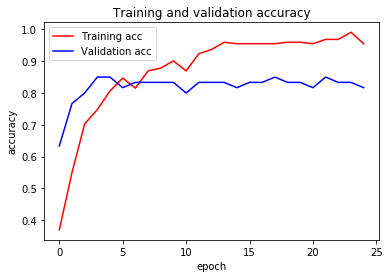

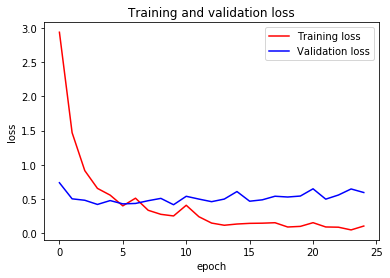

In [15]:
plot_graphs(history_googleNet)
preds=np.round(model_googleNet.predict(test_data),0)

In [16]:
classify_matrics_googleNet=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_googleNet)

              precision    recall  f1-score   support

       COVID       0.94      0.85      0.89        20
      NORMAL       0.76      0.65      0.70        20
   PNEUMONIA       0.76      0.95      0.84        20

   micro avg       0.82      0.82      0.82        60
   macro avg       0.82      0.82      0.81        60
weighted avg       0.82      0.82      0.81        60
 samples avg       0.82      0.82      0.82        60



# ResNet

In [17]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_resNet  = applications.ResNet50(include_top=False, weights='imagenet')
train_data,test_data,model_resNet,history_resNet,acc_resNet= transfer_learning(pretrained_model_resNet)

C:\Users\personal\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\personal\anaconda3\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 222 samples, validate on 60 samples
Epoch 1/25
222/222 [==============================] - 1s 4ms/step - loss: 1.2757 - acc: 0.2928 - val_loss: 1.0757 - val_acc: 0.3333
Epoch 2/25
222/222 [==============================] - 1s 3ms/step - loss: 1.1228 - acc: 0.3694 - val_loss: 1.0711 - val_acc: 0.3667
Epoch 3/25
222/222 [==============================] - 1s 3ms/step - loss: 1.1502 - acc: 0.3378 - val_loss: 1.0441 - val_acc: 0.5500
Epoch 4/25
222/222 [==============================] - 1s 3ms/step - loss: 1.0848 - acc: 0.3559 - val_loss: 1.0146 - val_acc: 0.3667
Epoch 5/25
222/222 [==============================] - 1s 3ms/step - loss: 1.0678 - acc: 0.4144 - val_loss: 1.0028 - val_acc: 0.6333
Epoch 6/25
222/222 [==============================] - 1s 3ms/step - loss: 1.0581 - acc: 0.4505 - val_loss: 0.9705 - val_acc: 0.7167
Epoch 7/25
222/222 [==============================] - 1s 4ms/step - loss: 1.0318 - acc: 0.4550 - val_loss: 0.9718 - val_acc: 0.6167
Epoch 8/25
222/222 [===========

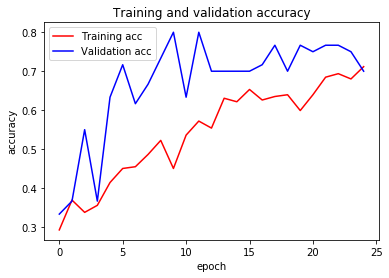

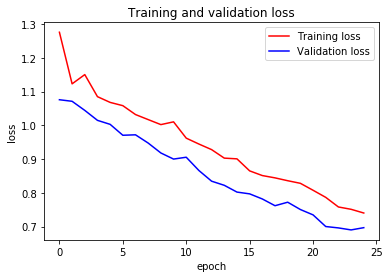

In [18]:
plot_graphs(history_resNet)
preds=np.round(model_resNet.predict(test_data),0)

In [19]:
classify_matrics_resNet=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_resNet)

              precision    recall  f1-score   support

       COVID       0.95      1.00      0.98        20
      NORMAL       0.63      0.60      0.62        20
   PNEUMONIA       1.00      0.15      0.26        20

   micro avg       0.81      0.58      0.68        60
   macro avg       0.86      0.58      0.62        60
weighted avg       0.86      0.58      0.62        60
 samples avg       0.58      0.58      0.58        60



C:\Users\personal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparing Models

In [23]:
print("Accuracies of Models")
print("VGG\t\t",acc_vgg)
print("Google Net\t",acc_googleNet)
print("ResNet\t\t",acc_resNet)


Accuracies of Models
VGG		 0.949999988079071
Google Net	 0.8166666626930237
ResNet		 0.699999988079071


# Testing a Single Image

In [21]:
def read_image(file_path):
   print("[INFO] loading and preprocessing image…") 
   image = load_img(file_path, target_size=(img_width, img_height))
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

[INFO] loading and preprocessing image…
ID: 0, Label: COVID 34.58%
ID: 1, Label: NORMAL 34.97%
ID: 2, Label: PNEUMONIA 30.45%
Final Decision:
.
..
...
ID: 1, Label: NORMAL


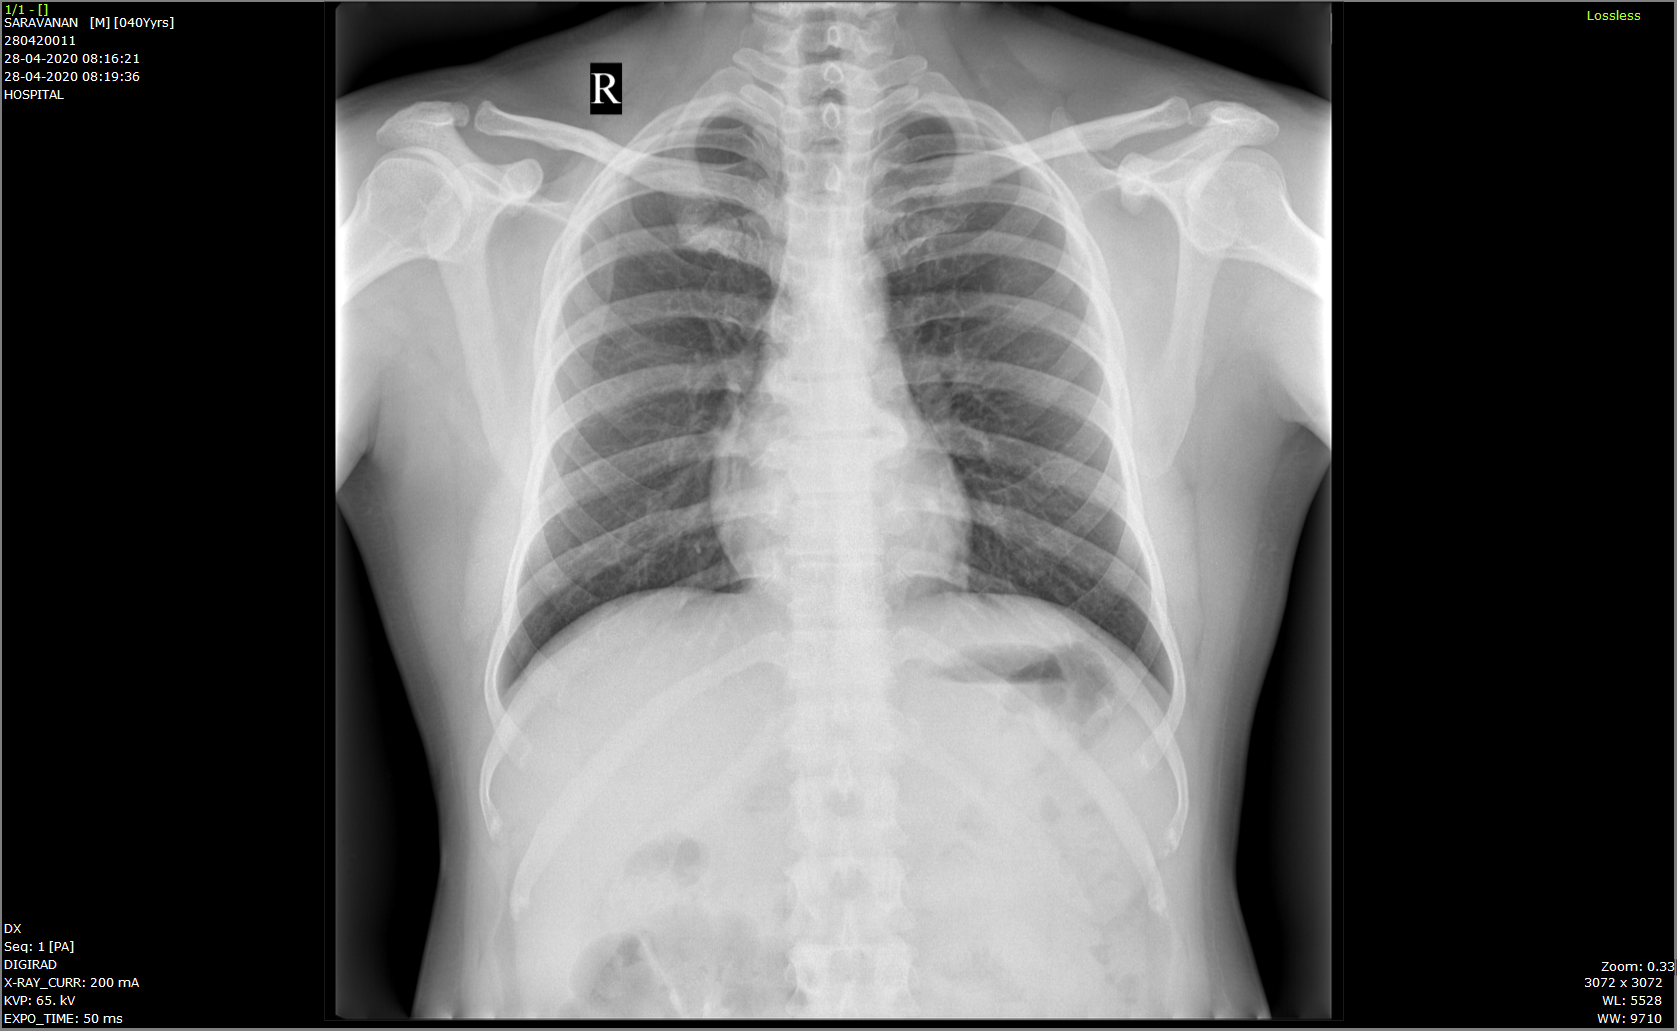

In [22]:
def test_single_image(pretrained_model,model,path):
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = pretrained_model.predict(images) 
  preds = model.predict_proba(bt_prediction)
  for idx, animal, x in zip(range(0,3), class_labels , preds[0]):
   print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
  print('Final Decision:')
  time.sleep(.5)
  for x in range(3):
   print('.'*(x+1))
   time.sleep(.2)
  class_predicted = model.predict_classes(bt_prediction)
  class_dictionary = generator_test.class_indices 
  inv_map = {v: k for k, v in class_dictionary.items()} 
  print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
  return load_img(path)
path = r'C:\Users\personal\Desktop\COVID2019\3class Classifier\testing\20011.jpg'
test_single_image(pretrained_model_googleNet,model_googleNet,path)